<a href="https://colab.research.google.com/github/cuducquang/ML_Project/blob/main/task1_resNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Colab Link
This cell provides a link to open the notebook in Google Colab, a cloud-based platform for running Jupyter Notebooks with GPU support. The badge ensures easy access to the notebook's environment.
- **Purpose**: Facilitates sharing and collaboration by linking directly to the Google Colab environment.
- **Output**: Displays a clickable badge to open the notebook in Colab.

### Install Keras Tuner
This cell installs the `keras-tuner` library, which is used for hyperparameter tuning of the neural network model.


In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 13.2 MB/s eta 0:00:00


## Import Libraries

### Import Libraries
This cell imports all necessary Python libraries and modules required for data processing, model building, training, and evaluation.

In [2]:
from google.colab import drive
import gdown
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import hashlib
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import numpy as np
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras_tuner import HyperParameters
from tensorflow import keras
import tensorflow as tf
from google.colab import files

## Download Training Dataset

### Download Training Dataset
This cell mounts Google Drive and downloads the training dataset (`train_images.zip`) from Google Drive using the `gdown` library.

In [3]:
drive.mount('/content/drive')

# Google Drive file ID (from the shared link)
file_id = "1CR4zCtNnPCWPrwLWej0Ft0wzkwJP3Bgs"
file_name = "train_images.zip"
file_path = "/content/" + file_name

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", file_path, quiet=False)
print(f"Downloaded: {file_path}")

Mounted at /content/drive


Downloading...
From (original): https://drive.google.com/uc?id=1CR4zCtNnPCWPrwLWej0Ft0wzkwJP3Bgs
From (redirected): https://drive.google.com/uc?id=1CR4zCtNnPCWPrwLWej0Ft0wzkwJP3Bgs&confirm=t&uuid=8c5c23a3-f437-4b8e-967f-23e7caaa0ed6
To: /content/train_images.zip
100%|██████████| 134M/134M [00:00<00:00, 152MB/s]

Downloaded: /content/train_images.zip


## Unzip Training Dataset

### Unzip Training Dataset
This cell extracts the contents of the `train_images.zip` file to a specified directory.

In [4]:
!unzip -q $file_path -d /content/extracted_folder

## Data Augmentation for Training and Validation Datasets

### Data Augmentation for Training and Validation Datasets
This cell sets up data augmentation for the training dataset and prepares the validation dataset for model training.

In [5]:
train_dir = '/content/extracted_folder/train'
val_dir = '/content/extracted_folder/val'

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, # 224, 224 , 3
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

val_generator = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 9785 images belonging to 10 classes.
Found 2451 images belonging to 10 classes.


Purpose:
- Training Data Augmentation: Enhances the training dataset with transformations to improve model generalization.
- Validation Data Preparation: Normalizes validation images without augmentation.

Key Components:
- Training Directory: /content/extracted_folder/train contains training images.
- Validation Directory: /content/extracted_folder/val contains validation images.

ImageDataGenerator for Training:
- rescale=1.0/255.0: Normalizes pixel values to [0, 1].
- rotation_range=10: Rotates images by up to 10 degrees.
- width_shift_range=0.05, height_shift_range=0.05: Shifts images horizontally/vertically by 5%.
- zoom_range=0.1: Zooms in/out by 10%.
- horizontal_flip=True: Randomly flips images horizontally.
- brightness_range=[0.8, 1.2]: Adjusts brightness by 80% to 120%.
- fill_mode='nearest': Fills missing pixels with the nearest value.

Training Generator:
- Loads images from train_dir.
- Resizes images to 224x224 pixels (required by resNet50).
- Uses a batch size of 32.
- class_mode='categorical': One-hot encodes labels for 10 classes.

Validation Generator:
- Only rescales images (no augmentation).
- Uses a larger batch size of 64 for efficiency.

Output:
- Found 9785 images belonging to 10 classes. (Training)
- Found 2451 images belonging to 10 classes. (Validation)

Why It Matters: Data augmentation prevents overfitting by creating varied training samples, while the validation set evaluates model performance on unmodified data.

## Build resNet50 Architecture Model

### Build resNet50 Architecture Model
This cell defines a function to build a resNet50-based model with tunable hyperparameters and sets up hyperparameter tuning using `keras-tuner`.

##### Purpose: Defines a customizable resNet50 model and sets up hyperparameter tuning to optimize its architecture.
#### Key Components:
    + Model Architecture:
        + Uses resNet50 without pre-trained weights (weights=None) and without the top layers (include_top=False).
        + Input shape is (224, 224, 3) (RGB images).
        + Adds GlobalAveragePooling2D to reduce spatial dimensions.
        + Dense Block 1:
        + Dense layer with tunable units (128 to 1024, step 128).
        + ReLU activation.
        + Dropout with tunable rate (0.1 to 0.3, step 0.1).
        + Dense Block 2:
        + Dense layer with tunable units (32 to 256, step 32).
        + ReLU activation.
        + Dropout with tunable rate (0.1 to 0.3, step 0.1).
        + Output Layer: Dense layer with 10 units (for 10 rice diceased) and softmax activation.
        + Compiled with Adam optimizer, categorical_crossentropy loss, and accuracy metric.
    + Hyperparameters:
        + dense1_units: Number of units in the first dense layer.
        + dropout_rate1: Dropout rate for the first block.
        + dense2_units: Number of units in the second dense layer.
        + dropout_rate2: Dropout rate for the second block.
        + learning_rate: Optimizer learning rate (0.001, 0.0005, 0.0001).
    + Callbacks:
        + EarlyStopping: Stops training if val_accuracy doesn’t improve for 5 epochs, restoring the best weights.
        + ReduceLROnPlateau: Reduces learning rate by half if val_loss doesn’t improve for 2 epochs (minimum 1e-6).
    + Tuner:
        + Uses kt_hyperband to search for the best hyperparameters.
        + Optimizes for val_accuracy over 20 trials.
        + Stores results in kt_bayesian/rice_variety_tuning.
    + Output: Displays the search space summary, detailing the tunable hyperparameters and their ranges.

In [7]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def build_model(hp):
    # Input layer
    inputs = Input(shape=(224, 224, 3))

    # Base model: ResNet50 without pretrained weights
    base_model = ResNet50(
        weights=None,
        include_top=False,
        input_tensor=inputs
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Dense block 1
    x = Dense(
        units=hp.Int('dense1_units', min_value=128, max_value=1024, step=128),
        activation='relu'
    )(x)
    x = Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)

    # Dense block 2
    x = Dense(
        units=hp.Int('dense2_units', min_value=32, max_value=256, step=32),
        activation='relu'
    )(x)
    x = Dropout(hp.Float('dropout_rate_2', min_value=0.1, max_value=0.3, step=0.1))(x)

    # Output layer: softmax 10 classes
    outputs = Dense(10, activation='softmax')(x)

    # Compile model
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4]),
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# Define the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,  # Reduces bad models quickly
    directory='kt_hyperband',
    project_name='rice_diseased_tuning'
)


# Display the search space
tuner.search_space_summary()

Search space summary
Default search space size: 5
dense1_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 128, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_rate_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0005, 0.0001], 'ordered': True}


## Fine-Tune Search

### Fine-Tune Search
This cell performs hyperparameter tuning using the `Hyperband` tuner and retrieves the best hyperparameters.

In [8]:
tuner.search(
    train_generator,  # Training dataset
    validation_data=val_generator,  # Validation dataset
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

Trial 21 Complete [00h 16m 16s]
val_accuracy: 0.507547914981842

Best val_accuracy So Far: 0.8751530051231384
Total elapsed time: 03h 59m 48s

Search: Running Trial #22

Value             |Best Value So Far |Hyperparameter
768               |512               |dense1_units
0.2               |0.3               |dropout_rate
96                |128               |dense2_units
0.1               |0.1               |dropout_rate_2
0.0005            |0.0001            |learning_rate
7                 |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/7
187/306 ━━━━━━━━━━━━━━━━━━━━ 46s 391ms/step - accuracy: 0.2222 - loss: 2.3407

KeyboardInterrupt: 

## Train Model

### Train Model
This cell builds and trains the model using the best hyperparameters found from tuning.

In [8]:
best_hps = HyperParameters()
best_hps.Fixed('dense1_units', 512)
best_hps.Fixed('dropout_rate', 0.3)
best_hps.Fixed('dense2_units', 128)
best_hps.Fixed('dropout_rate_2', 0.1)
best_hps.Fixed('learning_rate', 0.0001)

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

best_model.save("best_resNet_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 224s 530ms/step - accuracy: 0.2240 - loss: 2.1862 - val_accuracy: 0.2101 - val_loss: 2.8124 - learning_rate: 1.0000e-04
Epoch 2/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 121s 394ms/step - accuracy: 0.3443 - loss: 1.8494 - val_accuracy: 0.2448 - val_loss: 2.0110 - learning_rate: 1.0000e-04
Epoch 3/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 120s 390ms/step - accuracy: 0.4082 - loss: 1.7002 - val_accuracy: 0.3974 - val_loss: 1.7531 - learning_rate: 1.0000e-04
Epoch 4/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 120s 393ms/step - accuracy: 0.4681 - loss: 1.5504 - val_accuracy: 0.4190 - val_loss: 1.6238 - learning_rate: 1.0000e-04
Epoch 5/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 120s 392ms/step - accuracy: 0.4992 - loss: 1.4573 - val_accuracy: 0.5055 - val_loss: 1.4037 - learning_rate: 1.0000e-04
Epoch 6/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 120s 390ms/step - accuracy: 0.5398 - loss: 1.3552 - val_accuracy: 0.5537 - val_loss: 1.2556 - learning_rate: 1.0000e-04
Epoch 7/100
306/306 ━━━━━━━━━━━━━━

## Performance Evaluation

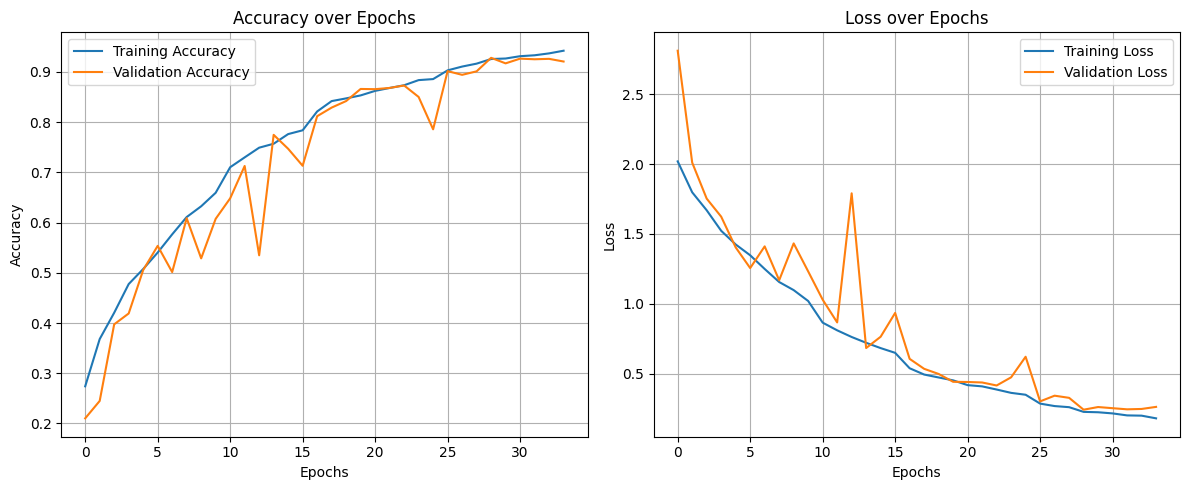

In [9]:
# Plot accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
# Access the history attribute
plt.plot(best_model.history.history['accuracy'], label='Training Accuracy')
plt.plot(best_model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
# Access the history attribute
plt.plot(best_model.history.history['loss'], label='Training Loss')
plt.plot(best_model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()